In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import zipfile
import tarfile
import os.path
import imageio
import io
import time
import re
import webdataset as wds

# Reading the ZipFile

We're taking the data out of the original zip file without unpacking.

In [3]:
src = zipfile.ZipFile("fat.zip")

In [4]:
files = [s for s in src.filelist if not s.is_dir()]

In [5]:
bydir = {}
for fname in files:
    dir = os.path.dirname(fname.filename)
    bydir.setdefault(dir, []).append(fname)
len(bydir.keys())

330

# Creating the Tar Files

The Falling Things dataset is a collection of videos of falling things. However, there are different ways in which it can be used to create training samples:

- each frame is a training sample, presented in random order
    - applications: pose estimation, stereo, monocular depth
- a small sequence of frames makes up a training sample 
    - applications: optical flow, motion segmentation, frame interpolatino
- each full sequence is a training sample (only 330 training samples)
    - applications: physical modeling, long time tracking
    
For random access datasets, the details of how data is broken up into training samples usually is hidden in the input pipeline. When using large scale, sequential training, this happens in a separate step while we generate training data sets.

Note also that videos in this dataset are not represented as video files but as sequences of frames, distinguished by filename. We are going to do the same thing in the WebDataset representation.

We first generate a full sequence dataset with a special structure of one shard per video:

- one `.tar` file per directory in the ZIP file
- duplicate the camera and object settings for each sample (so that we can later shuffle)
- one sample (=basename) per frame

This is a valid WebDataset, but it also still preserves the video data in sequence within each shard, giving us different processing options.

In [12]:
!rm -rf sequences shuffled
!mkdir sequences shuffled

In [13]:
def addfile(dst, name, data):
    assert isinstance(name, str), type(name)
    info = tarfile.TarInfo(name=name)
    info.size = len(data)
    info.uname, info.gname = "bigdata", "bigdata"
    info.mtime = time.time()
    dst.addfile(info, fileobj=io.BytesIO(data))

In [14]:
count = 0
for dir in sorted(bydir.keys()):
    tname = f"sequences/falling-things-{count:06d}.tar"
    nfiles = 0
    with tarfile.open(tname, "w|") as dst:
        fnames = bydir[dir]
        print(count, tname, dir)
        camera_settings = [s for s in fnames if "_camera_settings" in s.filename][0]
        camera_settings = src.open(camera_settings, "r").read()
        object_settings = [s for s in fnames if "_object_settings" in s.filename][0]
        object_settings = src.open(object_settings, "r").read()
        last_base = "NONE"
        for finfo in sorted(fnames, key=lambda x: x.filename):
            fname = finfo.filename
            if fname.startswith("_"):
                continue
            base = re.sub(r"\..*$", "", os.path.basename(fname))
            if base != last_base:
                #print("base:", base)
                addfile(dst, dir+"/"+base+".camera.json", camera_settings)
                addfile(dst, dir+"/"+base+".object.json", object_settings)
                last_base = base
            with src.open(fname, "r") as stream:
                data = stream.read()
            addfile(dst, fname, data)
            nfiles += 1
    #break
    count += 1

0 sequences/falling-things-000000.tar fat/mixed/kitchen_0
1 sequences/falling-things-000001.tar fat/mixed/kitchen_1
2 sequences/falling-things-000002.tar fat/mixed/kitchen_2
3 sequences/falling-things-000003.tar fat/mixed/kitchen_3
4 sequences/falling-things-000004.tar fat/mixed/kitchen_4
5 sequences/falling-things-000005.tar fat/mixed/kitedemo_0
6 sequences/falling-things-000006.tar fat/mixed/kitedemo_1
7 sequences/falling-things-000007.tar fat/mixed/kitedemo_2
8 sequences/falling-things-000008.tar fat/mixed/kitedemo_3
9 sequences/falling-things-000009.tar fat/mixed/kitedemo_4
10 sequences/falling-things-000010.tar fat/mixed/temple_0
11 sequences/falling-things-000011.tar fat/mixed/temple_1
12 sequences/falling-things-000012.tar fat/mixed/temple_2
13 sequences/falling-things-000013.tar fat/mixed/temple_3
14 sequences/falling-things-000014.tar fat/mixed/temple_4
15 sequences/falling-things-000015.tar fat/single/002_master_chef_can_16k/kitchen_0
16 sequences/falling-things-000016.tar fa

In [15]:
!ls -lth sequences/*.tar | head

-rw-rw-r-- 1 tmb tmb  46M Aug 30 19:02 sequences/falling-things-000329.tar
-rw-rw-r-- 1 tmb tmb  46M Aug 30 19:02 sequences/falling-things-000328.tar
-rw-rw-r-- 1 tmb tmb  26M Aug 30 19:02 sequences/falling-things-000327.tar
-rw-rw-r-- 1 tmb tmb  32M Aug 30 19:02 sequences/falling-things-000326.tar
-rw-rw-r-- 1 tmb tmb  33M Aug 30 19:02 sequences/falling-things-000325.tar
-rw-rw-r-- 1 tmb tmb 155M Aug 30 19:02 sequences/falling-things-000324.tar
-rw-rw-r-- 1 tmb tmb  89M Aug 30 19:02 sequences/falling-things-000323.tar
-rw-rw-r-- 1 tmb tmb 165M Aug 30 19:02 sequences/falling-things-000322.tar
-rw-rw-r-- 1 tmb tmb  90M Aug 30 19:01 sequences/falling-things-000321.tar
-rw-rw-r-- 1 tmb tmb  99M Aug 30 19:01 sequences/falling-things-000320.tar
ls: write error: Broken pipe


In [16]:
!tar tf sequences/falling-things-000000.tar | head

fat/mixed/kitchen_0/000000.camera.json
fat/mixed/kitchen_0/000000.object.json
fat/mixed/kitchen_0/000000.left.depth.png
fat/mixed/kitchen_0/000000.left.jpg
fat/mixed/kitchen_0/000000.left.json
fat/mixed/kitchen_0/000000.left.seg.png
fat/mixed/kitchen_0/000000.right.depth.png
fat/mixed/kitchen_0/000000.right.jpg
fat/mixed/kitchen_0/000000.right.json
fat/mixed/kitchen_0/000000.right.seg.png
tar: write error


# Frame-Level Training

To generate frame level training, we can simply shuffle the sequence data. For this to work, it is important that we associated the sequence level information (camera, object) with each frame, as we did in the construction of the sequence dataset.

We can now shuffle with:

```Bash
$ tarp cat -m 5 -s 500 -o - by-dir/*.tar | tarp split - -o shuffled/temp-%06d.tar
$ tarp cat -m 10 -s 1000 -o - shuffled/temp-*.tar | tarp split - -o shuffled/falling-things-shuffled-%06d.tar
```

If your machine has more memory, you can adjust the `-m` and `-s` options.

In [18]:
%%bash
tarp cat -m 5 -s 500 -o - sequences/*.tar | tarp split - -o shuffled/temp-%06d.tar && 
tarp cat -m 10 -s 1000 -o - shuffled/temp-*.tar | tarp split - -o shuffled/falling-things-shuffled-%06d.tar &&
rm shuffled/temp-*.tar

[info] # shuffle 500
[progress] # writing -
[progress] # source -
[progress] # shard shuffled/temp-000000.tar
[progress] # shard shuffled/temp-000001.tar
[progress] # shard shuffled/temp-000002.tar
[progress] # shard shuffled/temp-000003.tar
[progress] # shard shuffled/temp-000004.tar
[progress] # shard shuffled/temp-000005.tar
[progress] # shard shuffled/temp-000006.tar
[progress] # shard shuffled/temp-000007.tar
[progress] # shard shuffled/temp-000008.tar
[progress] # shard shuffled/temp-000009.tar
[progress] # shard shuffled/temp-000010.tar
[progress] # shard shuffled/temp-000011.tar
[progress] # shard shuffled/temp-000012.tar
[progress] # shard shuffled/temp-000013.tar
[progress] # shard shuffled/temp-000014.tar
[progress] # shard shuffled/temp-000015.tar
[progress] # shard shuffled/temp-000016.tar
[progress] # shard shuffled/temp-000017.tar
[progress] # shard shuffled/temp-000018.tar
[progress] # shard shuffled/temp-000019.tar
[progress] # shard shuffled/temp-000020.tar
[progress]

# Loading the Frame-Level Data

In [19]:
ds = wds.Dataset("shuffled/falling-things-shuffled-000033.tar").decode()

In [20]:
for sample in ds:
    break

In [21]:
sample.keys()

dict_keys(['__key__', 'object.json', 'right.json', 'left.json', 'left.jpg', 'right.seg.png', 'right.depth.png', 'camera.json', 'right.jpg', 'left.depth.png', 'left.seg.png'])

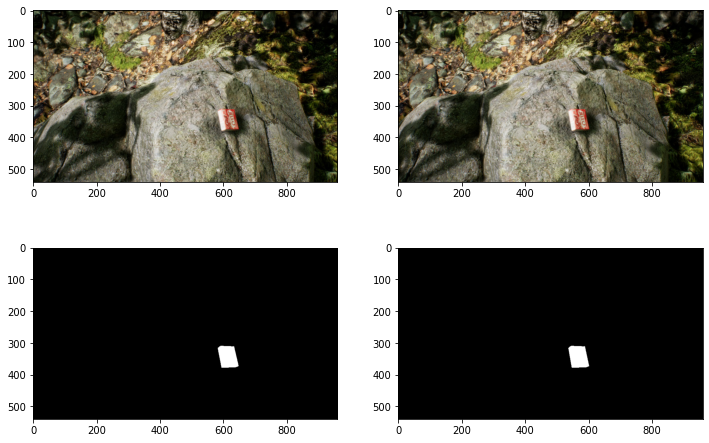

In [22]:
figsize(12, 8)
subplot(221); imshow(sample["left.jpg"])
subplot(222); imshow(sample["right.jpg"])
subplot(223); imshow(sample["left.seg.png"])
subplot(224); imshow(sample["right.seg.png"])

In [17]:
sample["camera.json"]

{'camera_settings': [{'name': 'left',
   'horizontal_fov': 64,
   'intrinsic_settings': {'fx': 768.1605834960938,
    'fy': 768.1605834960938,
    'cx': 480,
    'cy': 270,
    's': 0},
   'captured_image_size': {'width': 960, 'height': 540}},
  {'name': 'right',
   'horizontal_fov': 64,
   'intrinsic_settings': {'fx': 768.1605834960938,
    'fy': 768.1605834960938,
    'cx': 480,
    'cy': 270,
    's': 0},
   'captured_image_size': {'width': 960, 'height': 540}}]}

In [18]:
sample["object.json"]

{'exported_object_classes': ['011_banana_16k'],
 'exported_objects': [{'class': '011_banana_16k',
   'segmentation_class_id': 255,
   'fixed_model_transform': [[-36.39540100097656,
     -17.36479949951172,
     91.50869750976562,
     0],
    [-93.08769989013672, 3.4368999004364014, -36.37120056152344, 0],
    [3.1707000732421875, -98.4207992553711, -17.4153995513916, 0],
    [0.03660000115633011, 1.497499942779541, 0.44449999928474426, 1]],
   'cuboid_dimensions': [19.71739959716797,
    3.8649001121520996,
    7.406599998474121]}]}

In [19]:
sample["left.json"]

{'camera_data': {'location_worldframe': [-487.3075866699219,
   -429.8739929199219,
   208.91009521484375],
  'quaternion_xyzw_worldframe': [0.33379998803138733,
   0.3984000086784363,
   -0.5486999750137329,
   0.6547999978065491]},
 'objects': [{'class': '011_banana_16k',
   'visibility': 0.75,
   'location': [10.001999855041504, 11.863900184631348, 97.93609619140625],
   'quaternion_xyzw': [-0.982200026512146,
    0.12720000743865967,
    -0.04879999905824661,
    -0.1290999948978424],
   'pose_transform_permuted': [[0.06289999932050705,
     -0.2660999894142151,
     -0.961899995803833,
     0],
    [0.9628999829292297, -0.23739999532699585, 0.12870000302791595, 0],
    [0.26249998807907104, 0.9343000054359436, -0.24130000174045563, 0],
    [10.001999855041504, 11.863900184631348, 97.93609619140625, 1]],
   'cuboid_centroid': [10.001999855041504,
    11.863900184631348,
    97.93609619140625],
   'projected_cuboid_centroid': [558.450927734375, 363.05450439453125],
   'bounding_box'

In [20]:
sample["right.json"]

{'camera_data': {'location_worldframe': [-481.3999938964844,
   -428.82489013671875,
   208.91009521484375],
  'quaternion_xyzw_worldframe': [0.33379998803138733,
   0.3984000086784363,
   -0.5486999750137329,
   0.6547999978065491]},
 'objects': [{'class': '011_banana_16k',
   'visibility': 0.75,
   'location': [4.001999855041504, 11.86400032043457, 97.93599700927734],
   'quaternion_xyzw': [-0.982200026512146,
    0.12720000743865967,
    -0.04879999905824661,
    -0.1290999948978424],
   'pose_transform_permuted': [[0.06289999932050705,
     -0.2660999894142151,
     -0.961899995803833,
     0],
    [0.9628999829292297, -0.23739999532699585, 0.12870000302791595, 0],
    [0.26249998807907104, 0.9343000054359436, -0.24130000174045563, 0],
    [4.001999855041504, 11.86400032043457, 97.93599700927734, 1]],
   'cuboid_centroid': [4.001999855041504,
    11.86400032043457,
    97.93599700927734],
   'projected_cuboid_centroid': [511.389404296875, 363.05450439453125],
   'bounding_box': {'t